In [5]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'
# load Terra API for get data table from Terra
import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import pickle

import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Annotation of reccurent program

In [27]:
with open(f'{RESULT_TABLE}/MPs/Tumor/robustRPH.pickle', "rb") as input_file:
    robustRPH = pickle.load(input_file)

with open(f'{RESULT_TABLE}/MPs/Tumor/MP_order_color.pickle', "rb") as input_file:
    MP_order_color = pickle.load(input_file)
    order = MP_order_color['order']
    col_ha = MP_order_color['col_ha']
    bg_genes = MP_order_color['bg_genes']
    del MP_order_color

MP_Genesets = pd.read_csv(f'{RESULT_TABLE}/MPs/Tumor//MP_Programs.gmt',sep='\t',header=None,index_col=0).iloc[:,1:].T
        
def jaccard_index(c1,c2):
    c1 = set(c1)
    c2 = set(c2)
    overlap =  c1.intersection(c2)
    union = c1.union(c2)
    value = len(overlap)/len(union)
    return value

## Gavish et al. 2023 - Hallmarks of transcriptional intratumour heterogeneity across a thousand tumours

In [14]:
ref_ITH = pd.read_excel(f'{EXTERNAL_DATA}/meta_programs_2023-07-13.xlsx',sheet_name='Malignant')
ref_ITH = ref_ITH.loc[:,ref_ITH.columns!='Unassigned']

### Similarity of individual RHP with reference ITH

In [15]:
n_top = min(ref_ITH.shape[0],robustRPH.shape[0])
rph_ref_sm = robustRPH.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 78.67083333333333 mm
Incresing ncol


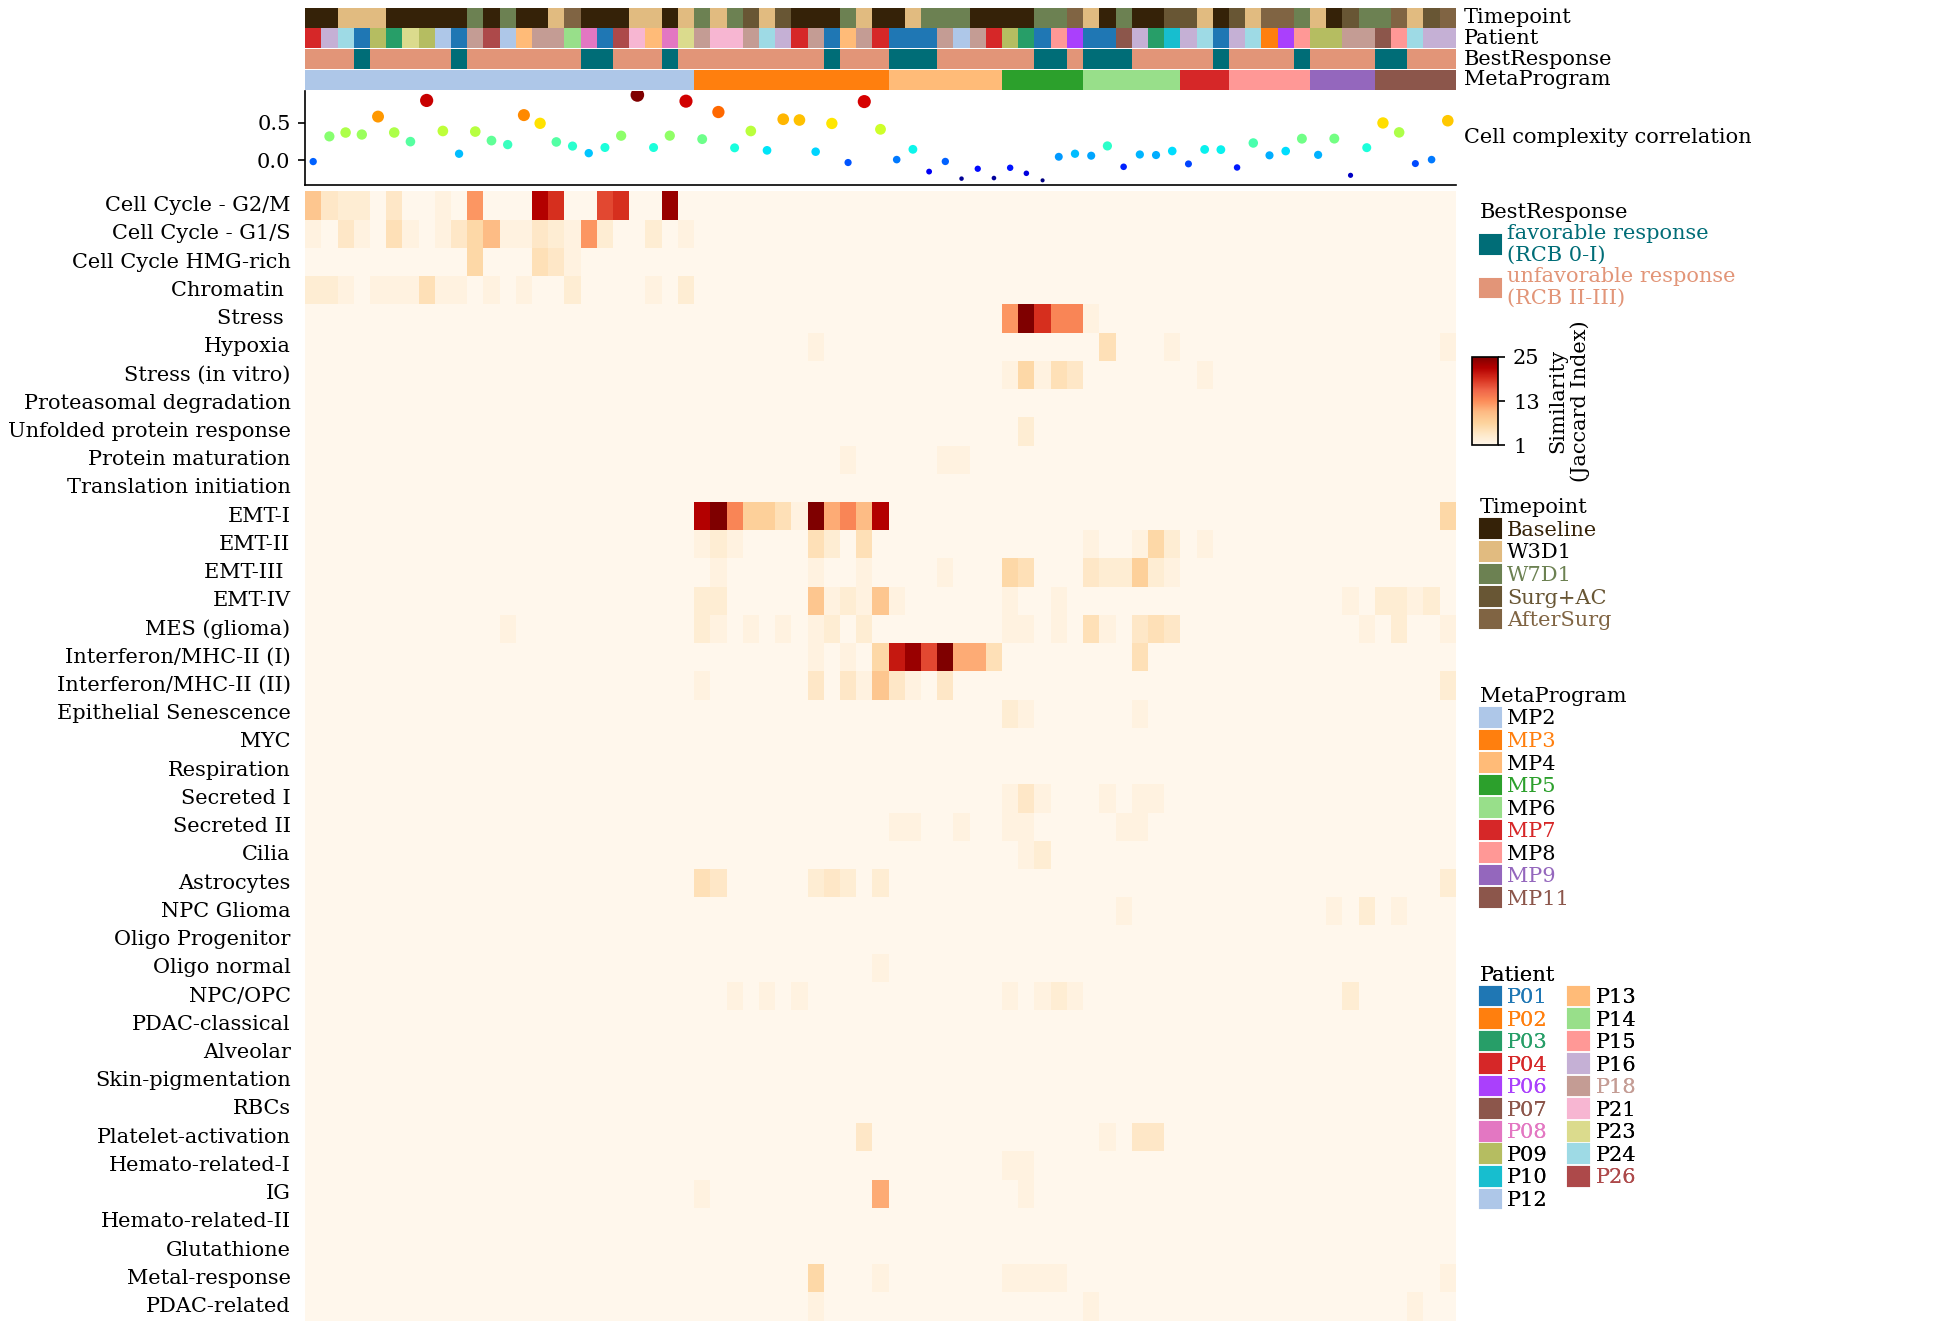

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 10),dpi=150)
cm = ClusterMapPlotter(data=rph_ref_sm.loc[:,order],
                       top_annotation=col_ha,
                       left_annotation=None,
                       show_rownames=True,
                       row_names_side='left',
                       row_cluster=False,col_cluster=False,
                       vmin=1,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='OrRd',rasterized=True)

### Similarity of metaRHP with reference ITH

<Axes: xlabel='0'>

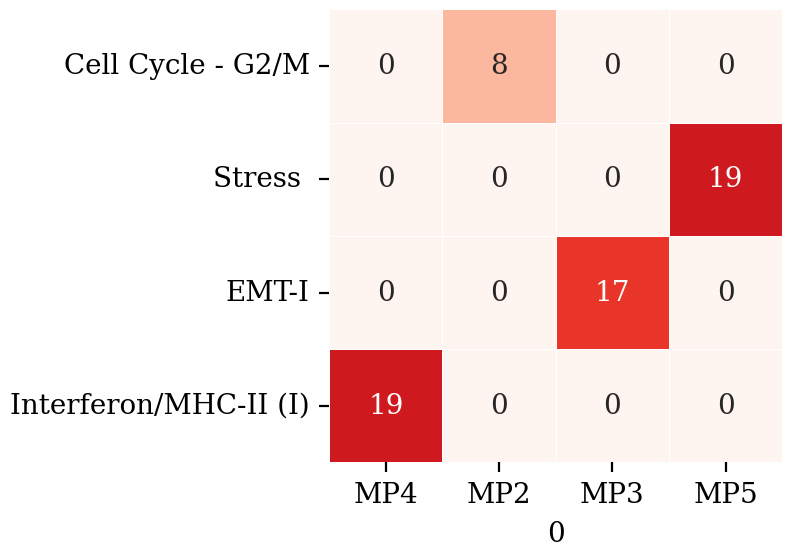

In [26]:
meta_ref_sm = MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0)
meta_ref_sm = meta_ref_sm.loc[((meta_ref_sm >= 7).sum(axis=1)>=1),((meta_ref_sm >= 7).sum(axis=0)>=1)]
fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=200)
sns.heatmap(meta_ref_sm,lw=.2,
              cmap='Reds',vmin=2,vmax=25,square=True,cbar_kws={'label':'Intersection'},ax=ax,
           annot=True,cbar=False)

## Hallmark and GO term bp/cc Geneset Enricher 

In [29]:
import gseapy as gp
MP_pathway = {}
for program in MP_Genesets:
    genelist = MP_Genesets[program].tolist()
    get = True
    while get:
        try:
            enr = gp.enrichr(gene_list=genelist,
                     gene_sets=[f"{EXTERNAL_DATA}/KEGG_2021_Human.gmt",
                                f"{EXTERNAL_DATA}/h.all.v2023.1.Hs.symbols.gmt",
                                f"{EXTERNAL_DATA}/c5.go.bp.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.cc.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.mf.v2023.1.Hs.symbols.gmt"],
                     organism='human',
                     background=bg_genes.tolist(),
                     outdir=None, # don't write to disk
                            )
            get = False
        except Exception as e:
            if e!='Error sending gene list, try again later':
                print(e)
    res = enr.results
    MP_pathway[program] = res


top_n = 10
enr_res = {}
with pd.ExcelWriter(f'{RESULT_TABLE}/MPs/Tumor/ITH_Enricher.xlsx') as file:
    for name,temp in MP_pathway.items():
        top_geneset = []
        for geneset,df in temp.groupby('Gene_set'):
            top_geneset.append(
                df.sort_values(['Adjusted P-value'],
                                ascending=True).head(top_n)
            )
        result = pd.concat(top_geneset,axis=0)
        result.to_excel(file, sheet_name = name, index=False)
        enr_res[name] = result
del temp,result

In [28]:
enr_res = pd.read_excel(f'{RESULT_TABLE}/MPs/Tumor/ITH_Enricher.xlsx', sheet_name=None)

## Manual annotation

based on the pathway enrichment analysis

In [30]:
MP_Genesets.columns.map(lambda x:int(x.replace('MP',''))).sort_values()

Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 11], dtype='int64', name=0)

In [34]:
for c in MP_Genesets:
    if 'MAP1B' in MP_Genesets[c].tolist():
        print(c)

MP9


## Final MP annotation

In [37]:
MP_anno_map = {
    'MP2':'Cell_Cycle',
    'MP3':'EMT-I',
    'MP4':'Interferon/MHCII(I)',
    'MP5':'Stress',
    'MP6':'EMT-II',
    'MP7':'ER-I',
    'MP8':'ER-II',
    'MP9':'Apelin',
    'MP11':'EMT-III'
}

In [38]:
with open(f'{RESULT_TABLE}/MPs/Tumor/MP_anno_map.pickle', 'wb') as handle:
    pickle.dump(MP_anno_map, handle, protocol=pickle.HIGHEST_PROTOCOL)